# Load Libraries

In [1]:
import os
os.chdir("..")
from parc import model
from parc import IO
from parc import losses
from parc import graphs
import keras
import numpy as np

# Initialize Parameters

### Adaptable Input Data 

In [2]:
#initialize input data characteristics
data_dir = "C:\\Users\\Austin Leonard\\parc_data\\data\\raw"      #input data file directory
case_numbers = 42                        #number of cases
del_t = 0.79                            #time step size (ns)
time_steps = 19                         #desired time steps for data processing
t_idx = del_t * np.arange(1,time_steps+1) #time index in nanoseconds
for i in range(len(t_idx)):
    t_idx[i] = round(t_idx[i], 2)

### Adaptable Model Parameters 

In [3]:
#initialize adaptable model parameters
input_size = 240
n_fields=2
n_timesteps=19
numFeatureMaps = 128

#initialize loss parameters
weight_loss = [4,1,1] #initial timestep weights, middle weights, late weights

### Adaptable Post-Processing 

# Initialization

### Parse and Split Data 

In [ ]:
#Parse the raw data and return microstructure data and temperature/pressure outputs
data_in, total_output, initial_vals, normalizing_constants = IO.parse_data(data_dir,time_steps,(del_t*(10**-9)))

np.save("output_data",total_output)
np.save("input_data",data_in)
np.save("initial_vals",initial_vals)
np.save("normalizing_constants.npy",normalizing_constants)

C:\Users\Austin Leonard\parc_data\data\raw/microstructures/data_01.pgm
485
[[0.         0.00206186 0.00412371 ... 0.99381443 0.99587629 0.99793814]
 [0.         0.00206186 0.00412371 ... 0.99381443 0.99587629 0.99793814]
 [0.         0.00206186 0.00412371 ... 0.99381443 0.99587629 0.99793814]
 ...
 [0.         0.00206186 0.00412371 ... 0.99381443 0.99587629 0.99793814]
 [0.         0.00206186 0.00412371 ... 0.99381443 0.99587629 0.99793814]
 [0.         0.00206186 0.00412371 ... 0.99381443 0.99587629 0.99793814]]


In [15]:
total_output = np.load("../parc_data/output_data.npy")
data_in = np.load("../parc_data/input_data.npy")
initial_vals = np.load("../parc_data/initial_vals.npy")
normalizing_constants = np.load("../parc_data/normalizing_constants.npy",allow_pickle=True)

In [16]:
# split data set
X_train, y_train, X_train_init, X_val, y_val, X_val_init, test_X, test_Y, test_X_init = IO.split_data(data_in,total_output,initial_vals,splits=[0.6, 0.2, 0.2])

42
25
33
42
(25, 240, 240, 2)
(25, 240, 240, 19, 4)
(25, 240, 240, 2)
(8, 240, 240, 2)
(8, 240, 240, 19, 4)
(8, 240, 240, 2)
(9, 240, 240, 2)
(9, 240, 240, 19, 4)
(9, 240, 240, 2)


### Prepare PARC

In [6]:
#initilize model parameters
parc_model = model.PARC(input_size=240, n_fields=2, n_timesteps=time_steps, n_featuremaps=numFeatureMaps)
parc_model.build()
loss = ["mse", "mse"]
loss_weights = [1, 1]
optimizer = keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9, beta_2=0.999)
metrics = ["acc"]
parc_model.compile(loss = loss,loss_weights = loss_weights,optimizer = optimizer,metrics = metrics)

# Training

### 5-Dimensional Format Training 

In [ ]:
#train the model using training set 
#history = parc_model.fit(
#    x=[X_train, x_tn_init],
#    y=[y_train[:, :, :, 1:, :1], y_train[:, :, :, 1:, 2:3]],
#    validation_data=([X_val, x_val_init], [y_val[:, :, :, :, :1], y_val[:, :, :, :, 2:3]]),
#    batch_size=1,
#    epochs=300,
#)

### 4-Dimensional Format Training 

In [17]:
#reshape to match old data format
y_train = IO.reshape_old(y_train)
y_val = IO.reshape_old(y_val)
test_Y = IO.reshape_old(test_Y)

#train the model using training set, skip this part if already trained
#history = parc_model.fit(
#    x=[X_train, X_train_init],
#    y=[y_train[:, :, :, :38], y_train[:, :, :, 38:]],
#    validation_data=([X_val, X_val_init], [y_val[:, :, :, :38], y_val[:, :, :, 38:]]),
#    batch_size=1,
#    epochs=300,
#)

Starting shape of data:  (25, 240, 240, 19, 4)
Reformatted data shape:  (25, 240, 240, 76)
Starting shape of data:  (8, 240, 240, 19, 4)
Reformatted data shape:  (8, 240, 240, 76)
Starting shape of data:  (9, 240, 240, 19, 4)
Reformatted data shape:  (9, 240, 240, 76)


In [8]:
#save trained model weights
#parc_model.save_weights("../parc_data/PARC_trained_data.h5")

#load trained model weights
parc_model.load_weights("../parc_data/preTrain.h5")

# Prediction

In [18]:
#prediction using trained model parameters
pred = parc_model.predict([test_X,test_X_init])

1/1 [==============================] - 320s 320s/step


In [19]:
#reshape to match new data format
test_Y = IO.reshape_new(test_Y)
pred = IO.reshape_new(pred[0],2)

Starting shape of data:  (9, 240, 240, 76)
Reformatted data shape:  (9, 240, 240, 19, 4)
Starting shape of data:  (9, 240, 240, 38)
Reformatted data shape:  (9, 240, 240, 19, 2)


# Losses

In [20]:
#definition of temperature prediction and ground truth with rescaling
norm_T_min = normalizing_constants.item().get('Temperature').get('min')
norm_T_max = normalizing_constants.item().get('Temperature').get('max')
Temp_pred = pred[:,:,:,:,0]
Temp_pred = IO.rescale(Temp_pred,norm_T_min,norm_T_max)
Temp_gt = test_Y[:,:,:,:,0]
Temp_gt = IO.rescale(Temp_gt,norm_T_min,norm_T_max)

#definition of pressure prediction and ground truth with rescaling
norm_P_min = normalizing_constants.item().get('Pressure').get('min')
norm_P_max = normalizing_constants.item().get('Pressure').get('max')
Pres_pred = pred[:,:,:,:,1]
Pres_pred = IO.rescale(Pres_pred,norm_P_min,norm_P_max)
Pres_gt = test_Y[:,:,:,:,1]
Pres_gt = IO.rescale(Pres_gt,norm_P_min,norm_P_max)

In [21]:
#calculate root mean squared, r2 score, and losses for temperature
rmse = losses.rmse(Temp_gt,Temp_pred)
r2 = losses.r2(Temp_gt,Temp_pred)
loss_cv = losses.step_weighted_loss(Temp_gt,Temp_pred,weight_loss)
#step_loss = losses.step_weighted_physical_loss(Temp_gt,Temp_pred,loss_cv)
state_loss = losses.state_weighted_loss(Temp_gt,Temp_pred)

temp loss:  tf.Tensor(
[[[3.07257570e+03 5.88547978e+02 8.21552804e+02 ... 9.05139215e+02
   2.47872792e+03 1.61772578e+03]
  [6.02213685e+02 5.26943984e+02 5.07543777e+02 ... 7.99311900e+02
   5.56262991e+02 4.39958913e+03]
  [1.03178313e+03 4.24336687e+02 5.25402410e+02 ... 1.49049605e+03
   5.71400856e+02 6.21091303e+03]
  ...
  [4.58512694e+02 9.10458826e+02 1.31023890e+02 ... 2.55770366e+03
   1.53707476e+03 8.90578222e+02]
  [1.29544314e+03 1.77753578e+03 2.22126905e+02 ... 2.05022714e+03
   1.79405602e+03 7.81744330e+02]
  [2.62927203e+03 1.46889113e+03 1.58450955e+03 ... 3.25896566e+03
   1.61872380e+03 1.16326077e+03]]

 [[1.51951752e+03 4.71243388e+02 1.05408761e+03 ... 2.36676754e+03
   3.72605996e+03 1.84228073e+03]
  [2.38249558e+02 4.31414713e+02 2.14323475e+02 ... 1.66189838e+03
   1.20578245e+03 2.54040263e+03]
  [2.49954543e+02 1.25209311e+03 4.17962246e+02 ... 4.14271535e+03
   1.18294123e+03 1.79063716e+03]
  ...
  [2.34873071e+03 1.30853260e+03 1.58078771e+03 ... 7.

# Graphs

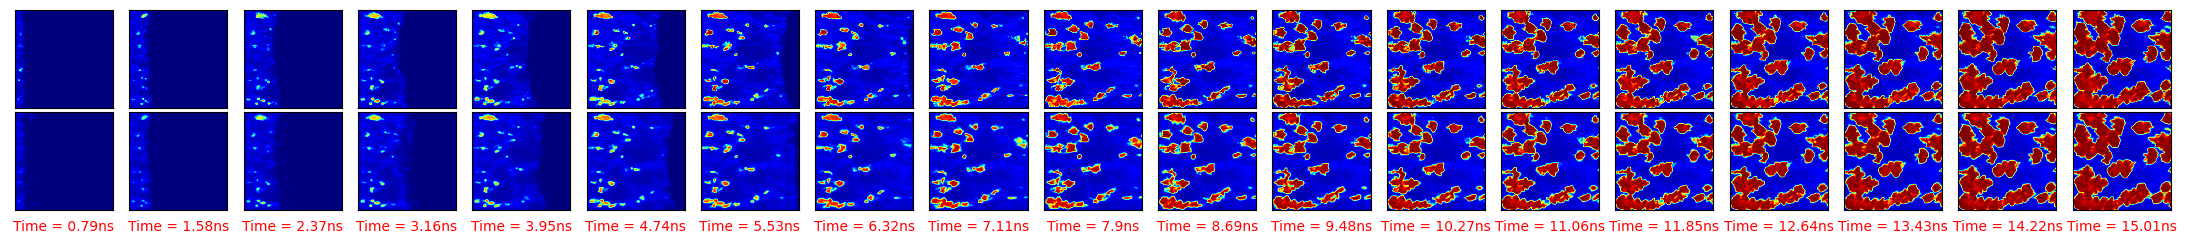

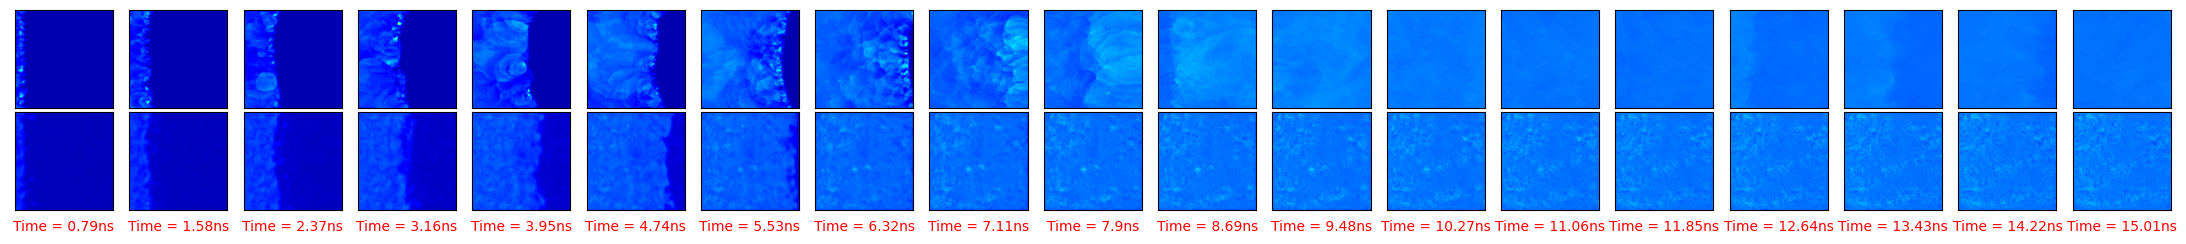

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


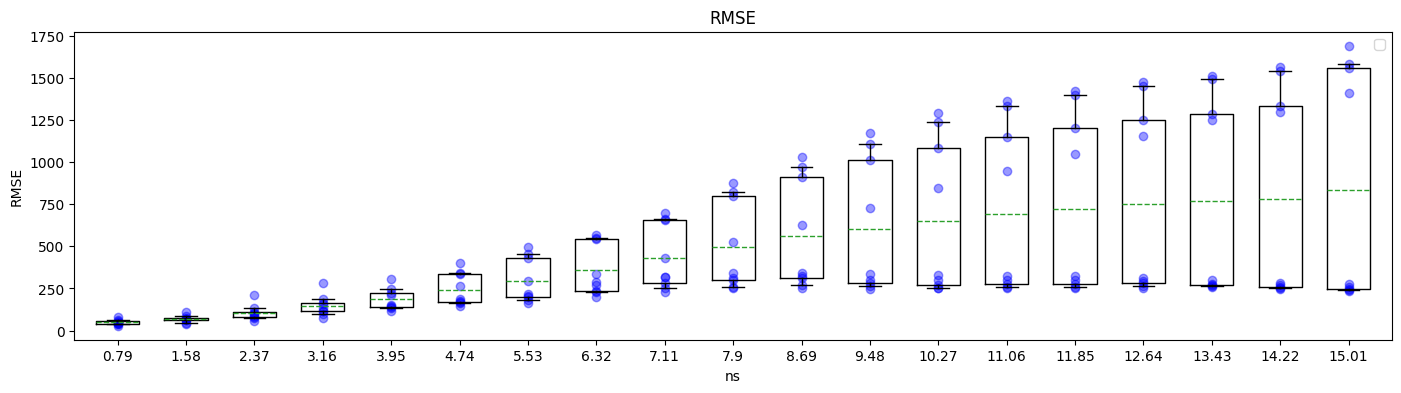

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


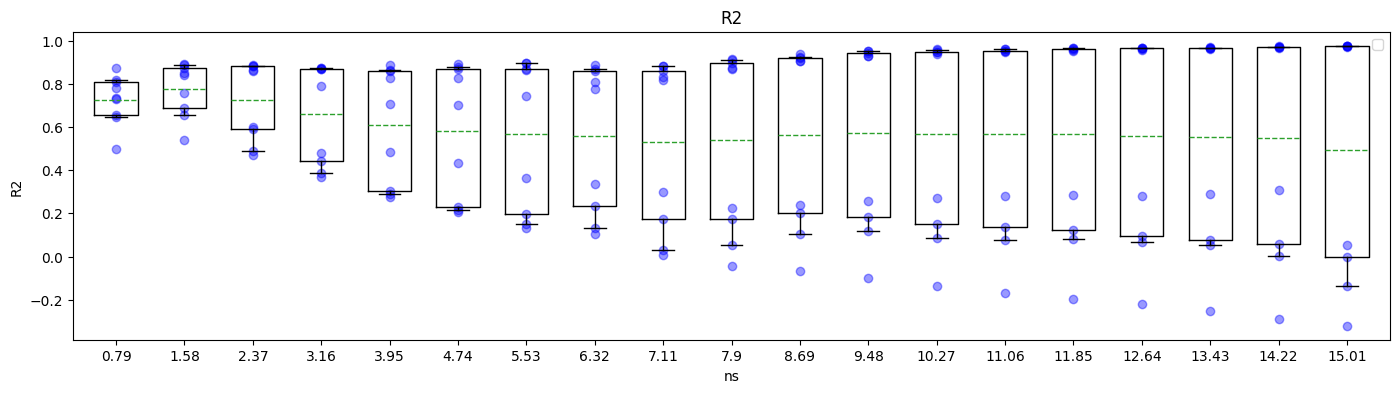

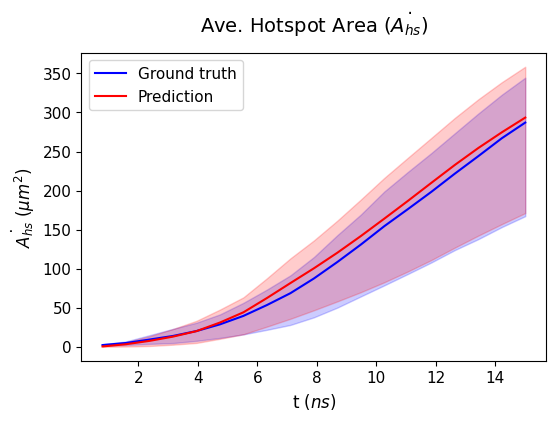

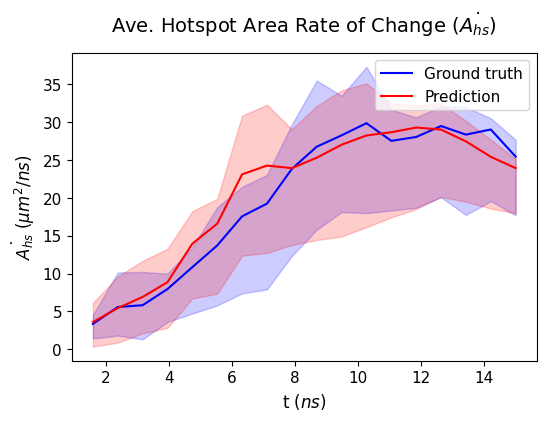

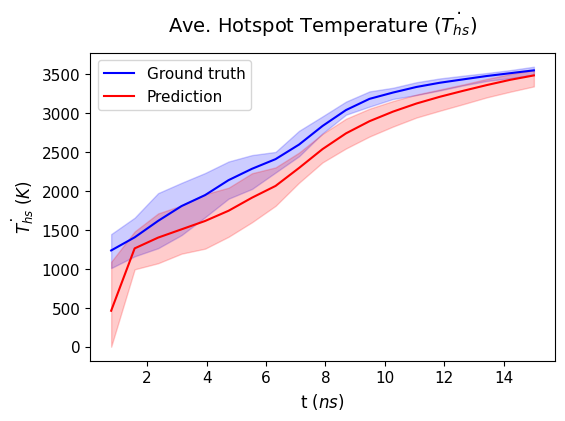

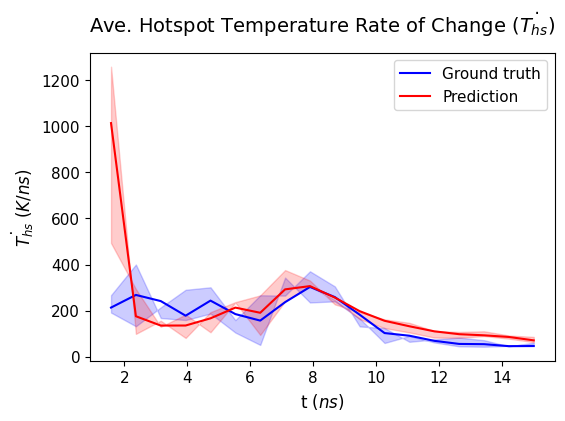

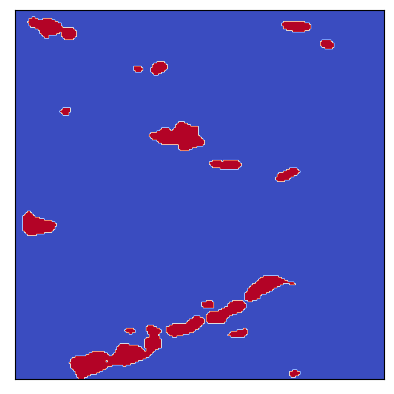

In [24]:
#create plots for data
graphs.visualize_inference(Temp_gt,Temp_pred,t_idx,2,norm_T_min,norm_T_max)
graphs.visualize_inference(Pres_gt,Pres_pred,t_idx,2,norm_P_min,norm_P_max)
graphs.plot_rmse(rmse,t_idx)
graphs.plot_r2(r2,t_idx)
graphs.plot_hotspot_area(Temp_gt,Temp_pred,t_idx)
graphs.plot_hotspot_area_dot(Temp_gt,Temp_pred,t_idx,del_t)
graphs.plot_hotspot_temperature(Temp_gt,Temp_pred,t_idx)
graphs.plot_hotspot_temp_dot(Temp_gt,Temp_pred,t_idx,del_t)
graphs.plot_saliency(Temp_pred,5)